In [23]:
import pandas as pd
import numpy as np
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src')
import mcar
import preprocess
from mcar import mcar_test
from preprocess import preprocess2
from preprocess import preprocess
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [12]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [74]:
df = pd.read_csv('../data/googleplaystore.csv')
df2 = pd.read_csv('../data/googleplaystore_user_reviews.csv')

In [30]:
df_preprocessed = preprocess2(df,df2)

In [31]:
df_preprocessed.shape

(9671, 14)

In [32]:
X = df_preprocessed.drop(['Installs'], axis=1)
y = df_preprocessed['Installs']

In [34]:
cat_frs = ['Category','Genres','Current_Ver_truncated','Android_Ver_truncated','Type','Content Rating']

In [40]:
Paid = df_preprocessed[df_preprocessed['Type']=='Paid']
Free = df_preprocessed[df_preprocessed['Type']=='Free']
from matplotlib import pyplot as plt

In [76]:
X = df_preprocessed.drop(['Installs'], axis=1)
y = df_preprocessed['Installs']

In [79]:
barlist=plt.bar([1,2,3,4], [1,2,3,4])
barlist[0].set_color('r')
plt.show()

0.0    3143
1.0    2614
3.0    1990
2.0    1924
Name: Installs, dtype: int64

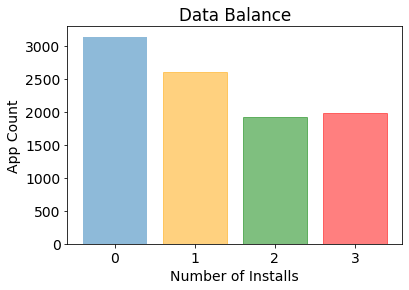

In [92]:
objects = [0,1,2,3]
y_pos = np.arange(len(objects))
performance = [3143,2614,1924,1990]

barlist = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('App Count')
plt.xlabel('Number of Installs')
plt.title('Data Balance')
#barlist[0].set_color('b')
barlist[1].set_color('orange')
barlist[2].set_color('g')
barlist[3].set_color('r')
plt.savefig('../figures/dist.png',dpi=300)
plt.show()

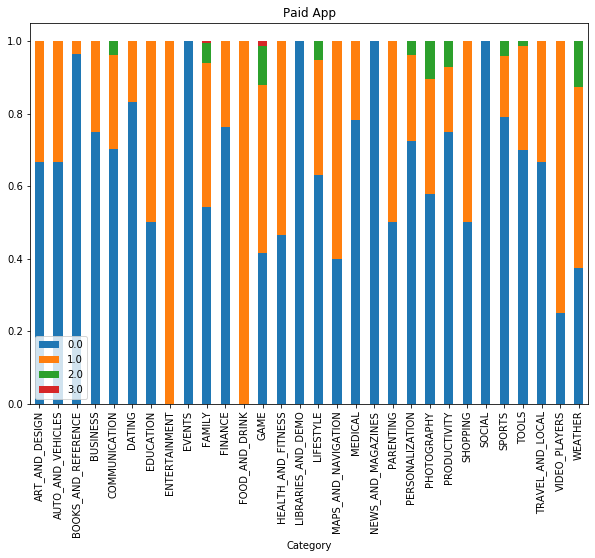

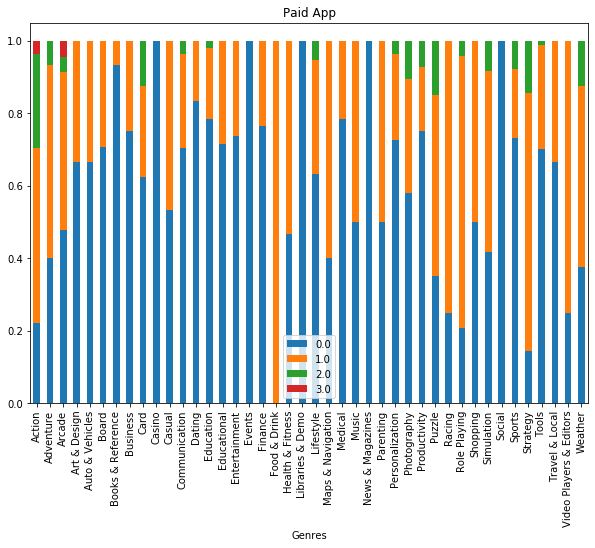

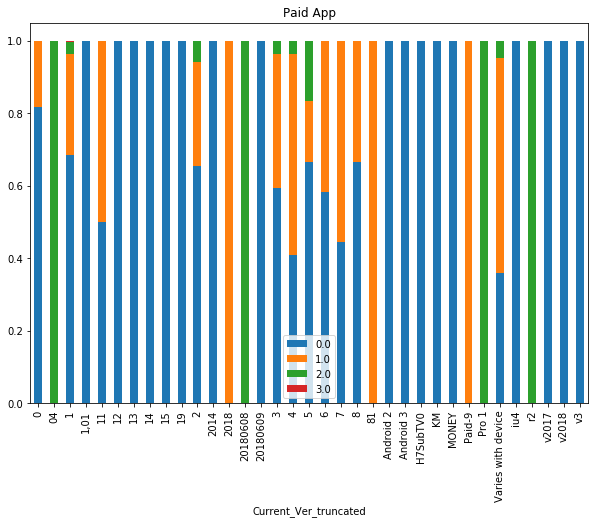

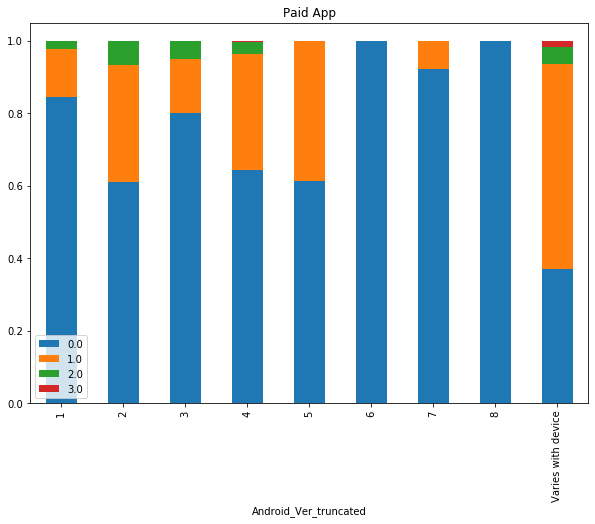

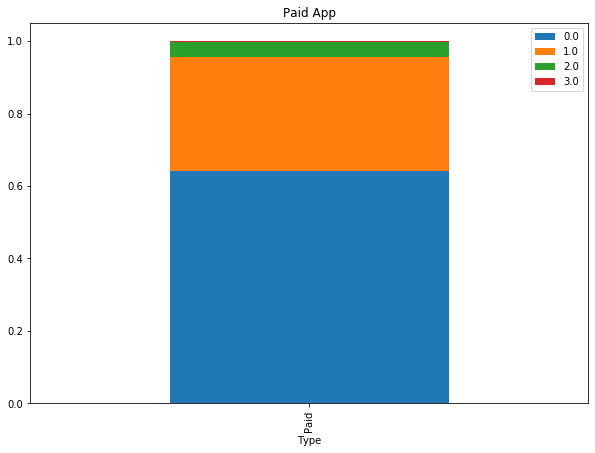

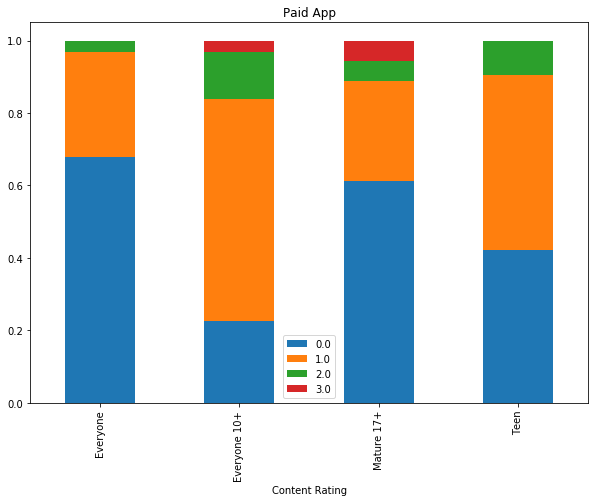

In [42]:
for i in range(len(cat_frs)):
    cat = Paid.groupby([cat_frs[i],'Installs']).size().unstack()
    cat_norm = cat.div(cat.sum(axis=1),axis=0)
    cat_norm.plot(kind='bar', stacked=True,figsize=(,7))
    plt.xlabel(cat_frs[i])
    plt.legend()
    plt.title('Paid App')
    plt.savefig('../figures/bar%d.png' % i ,dpi=300)
    plt.show()

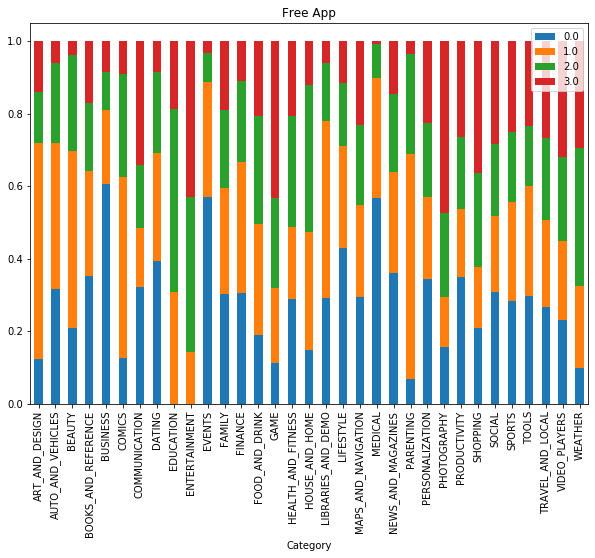

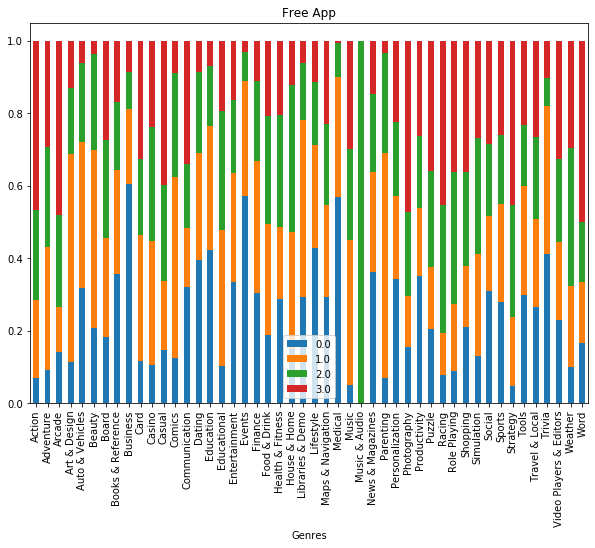

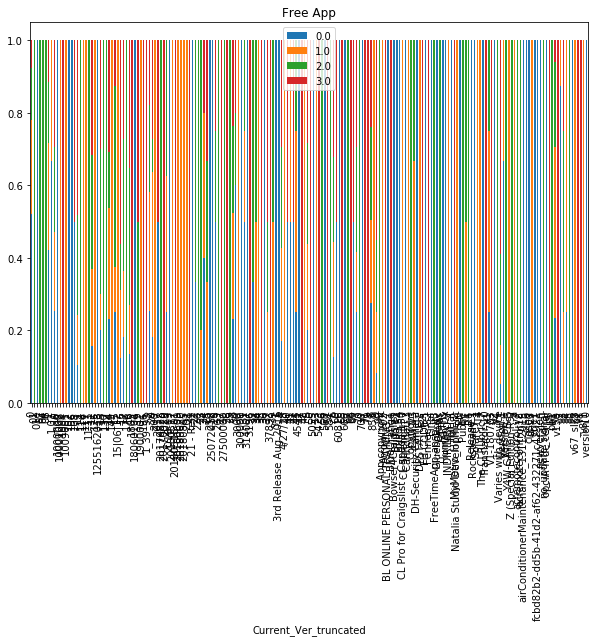

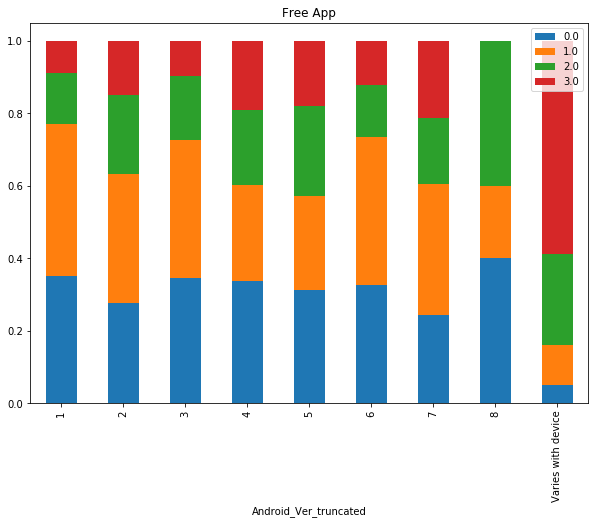

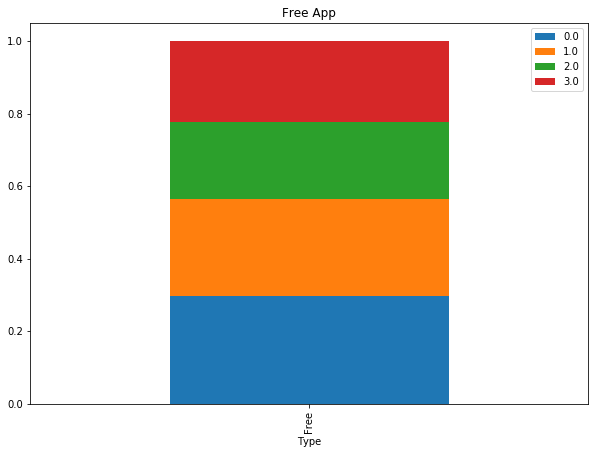

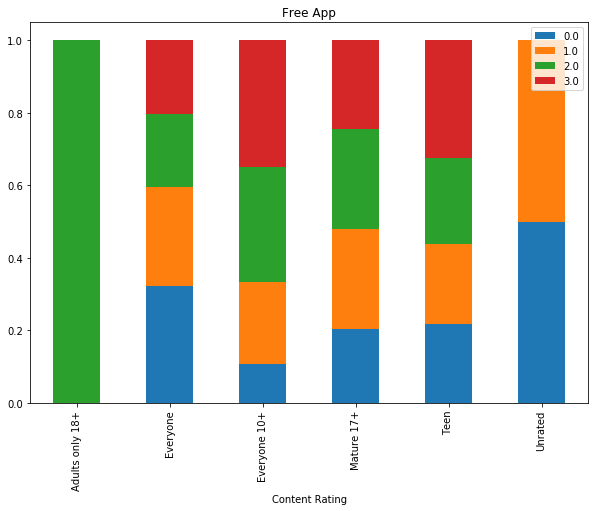

In [44]:
for i in range(len(cat_frs)):
    cat = Free.groupby([cat_frs[i],'Installs']).size().unstack()
    cat_norm = cat.div(cat.sum(axis=1),axis=0)
    cat_norm.plot(kind='bar', stacked=True,figsize=(10,7))
    plt.xlabel(cat_frs[i])
    plt.legend()
    plt.title('Free App')
    #plt.savefig('../figures/FreeBar%d.png' % i ,dpi=300)
    plt.show()

In [16]:
train_temp = pd.concat([X,y],axis=1)
train_temp.columns

Index(['Category', 'Rating', 'Reviews', 'Size', 'Type', 'Price',
       'Content Rating', 'Genres', 'Last Updated', 'Num_of_Characters',
       'Size_varies', 'Current_Ver_truncated', 'Android_Ver_truncated',
       'Installs'],
      dtype='object')

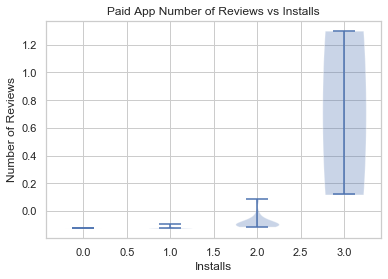

In [36]:
dataset = [Paid_Train[Paid_Train['Installs']==0.0]['Reviews'].values,
           Paid_Train[Paid_Train['Installs']==1.0]['Reviews'].values,
           Paid_Train[Paid_Train['Installs']==2.0]['Reviews'].values,
           Paid_Train[Paid_Train['Installs']==3.0]['Reviews'].values]
plt.violinplot(dataset = dataset,positions = [0.0,1.0,2.0,3.0])
plt.xlabel('Installs')
plt.ylabel('Number of Reviews')
plt.title('Paid App Number of Reviews vs Installs')
#plt.savefig('../figures/PaidAppReviews.png',dpi=300)
plt.show()

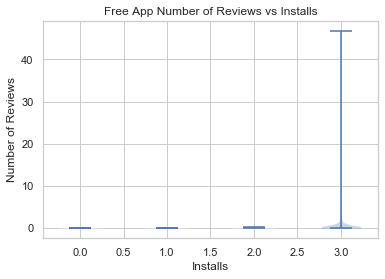

In [96]:
dataset = [Free_Train[Free_Train['Installs']==0.0]['Reviews'].values,
           Free_Train[Free_Train['Installs']==1.0]['Reviews'].values,
           Free_Train[Free_Train['Installs']==2.0]['Reviews'].values,
           Free_Train[Free_Train['Installs']==3.0]['Reviews'].values]
plt.violinplot(dataset = dataset,positions = [0.0,1.0,2.0,3.0])
plt.xlabel('Installs')
plt.ylabel('Number of Reviews')
plt.title('Free App Number of Reviews vs Installs')
plt.savefig('../figures/FreeAppReviews.png',dpi=300)
plt.title('Free App Number of Reviews vs Installs')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


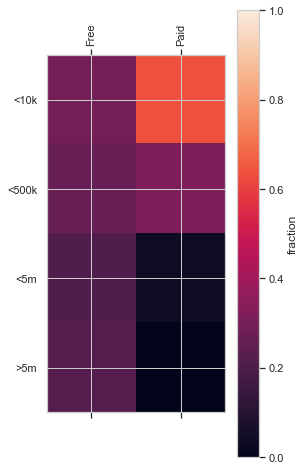

In [88]:
count_matrix = df_preprocessed.groupby(['Type', 'Installs']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
#print(count_matrix_norm)
plt.matshow(count_matrix_norm.T,vmin=0,vmax=1)
plt.xticks(np.arange(count_matrix_norm.shape[0]),count_matrix_norm.index,rotation=90)
plt.yticks(np.arange(count_matrix_norm.shape[1]),count_matrix_norm.columns)
plt.colorbar(label='fraction')
plt.tight_layout()
plt.savefig('../figures/matTypeInstall.png',dpi=350)
plt.show()

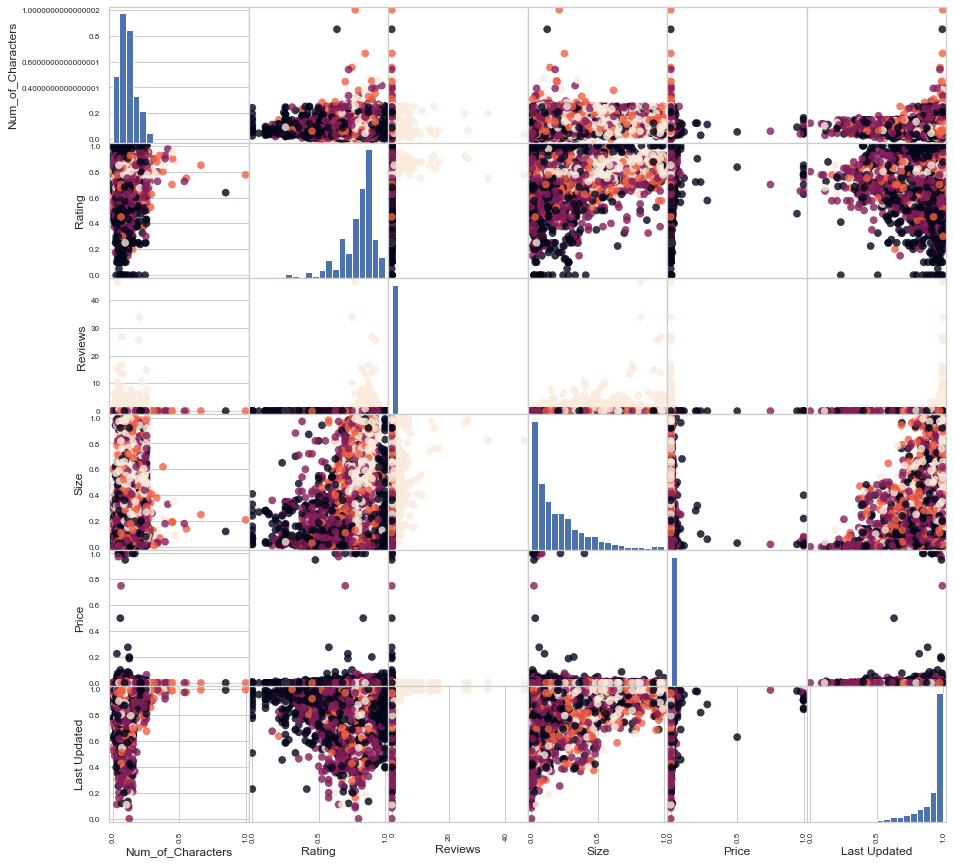

In [38]:
pd.plotting.scatter_matrix(train_temp[cont_frs],c = train_temp['Installs'], figsize=(15, 15), marker='o',
                           hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.savefig('../figures/scatter_matrix_conts.png',dpi=350)
#plt.savefig('figures/scatter_matrix_conts.png',dpi=300)
plt.show()

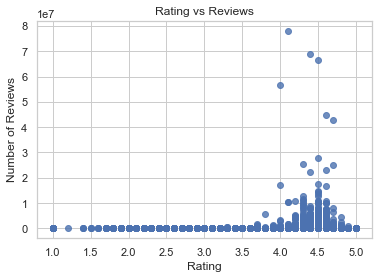

In [87]:
plt.scatter(df_preprocessed['Rating'], df_preprocessed['Reviews'],alpha=0.8)
plt.title('Rating vs Reviews')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.savefig('../figures/Rating&Review.png',dpi=300)
plt.show()
#cont_frs = ['Rating','Reviews','Size','Price','Last Updated']

In [45]:
def ML_pipeline_xgb_permutation(X, y, random_state, n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state = random_state)
    standard_transformer = Pipeline(steps=[('standard', StandardScaler())])
    onehot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    ordinal_transformer1 = Pipeline(steps=[('ordinal1', OrdinalEncoder(categories = [['Free','Paid']]))])
    ordinal_transformer2 = Pipeline(steps=[('ordinal2', OrdinalEncoder(categories = [['Everyone', 'Everyone 10+', 'Teen', 'Mature 17+', 'Adults only 18+','Unrated']]))])                              
    XGB = xgboost.XGBClassifier()
    preprocessor = ColumnTransformer(
    transformers=[
        ('standard', standard_transformer, cont_frs),
        ('ordinal1',ordinal_transformer1,['Type']),
        ('ordinal2',ordinal_transformer2,['Content Rating']),
        ('onehot', onehot_transformer, cat_frs_onehot)])

    param_grid = {'classifier__learning_rate': [0.03],
              'classifier__n_estimators': [100],
              'classifier__random_state': [random_state],
              'classifier__missing': [np.nan], 
              'classifier__max_depth': [20,30,40,50],
              'classifier__colsample_bytree': [0.75],              
              'classifier__subsample': [0.66]}

    xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGB)])

    grid = GridSearchCV(xgb, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                    cv=kf, return_train_score = True,iid=True,n_jobs=-1)
    grid.fit(X_other, y_other)
    feature_names = cont_frs + cat_frs_ordinal + \
                list(grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(cat_frs_onehot))
    return grid, X_test, y_test, np.array(feature_names)

In [46]:
cont_frs = ['Reviews','Size','Price','Last Updated','Num_of_Characters','Rating']
cat_frs_onehot = ['Category','Genres','Current_Ver_truncated','Android_Ver_truncated']
cat_frs_ordinal = ['Type','Content Rating']
grid, X_test, y_test, feature_names = ML_pipeline_xgb_permutation(X,y,1030,4)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.8559979317476732
0.8594315245478036
{'classifier__colsample_bytree': 0.75, 'classifier__learning_rate': 0.03, 'classifier__max_depth': 20, 'classifier__missing': nan, 'classifier__n_estimators': 100, 'classifier__random_state': 1030, 'classifier__subsample': 0.66}


In [47]:
ftr_names = X_test.columns

In [48]:
import pickle
file = open('../results/grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

In [49]:
import pickle
file = open('../results/grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8594315245478036
test baseline =  0.32506459948320415
shuffling Category
   shuffled test score: 0.857 +/- 0.001
shuffling Rating
   shuffled test score: 0.828 +/- 0.004
shuffling Reviews
   shuffled test score: 0.27 +/- 0.008
shuffling Size
   shuffled test score: 0.857 +/- 0.003
shuffling Type
   shuffled test score: 0.86 +/- 0.001
shuffling Price
   shuffled test score: 0.842 +/- 0.002
shuffling Content Rating
   shuffled test score: 0.859 +/- 0.001
shuffling Genres
   shuffled test score: 0.855 +/- 0.001
shuffling Last Updated
   shuffled test score: 0.857 +/- 0.003
shuffling Num_of_Characters
   shuffled test score: 0.859 +/- 0.003
shuffling Size_varies
   shuffled test score: 0.859 +/- 0.0
shuffling Current_Ver_truncated
   shuffled test score: 0.86 +/- 0.002
shuffling Android_Ver_truncated
   shuffled test score: 0.859 +/- 0.001


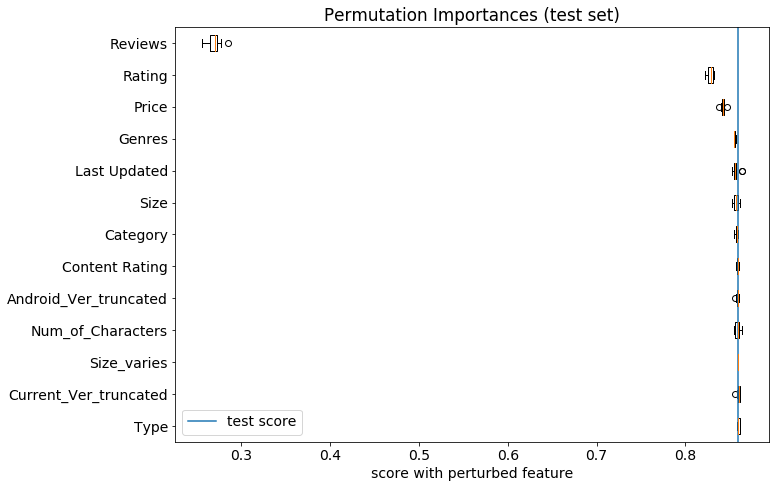

In [50]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(11,7))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/permutation.png',dpi=300)
plt.show()

In [51]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the xgboost model
explainer = shap.TreeExplainer(grid.best_estimator_[1]) # grid.best_estimator_[1] gives the classifier, second step in the pipeline
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test) # grid.best_estimator_[0] gives the preprocesser, first step in the pipeline
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(1935, 275)
(4, 1000, 275)


In [52]:
index = 5 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 1 predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = X_test_transformed[index,:],feature_names = feature_names)

0.7217148


In [53]:
index = 1 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 1 predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = X_test_transformed[index,:],feature_names = feature_names)

0.56948566


In [54]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = [0,1,2,3]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots(figsize=(7, 7))
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('../figures/confusion_matrix.png',dpi=300)
    return ax

0.8594315245478036


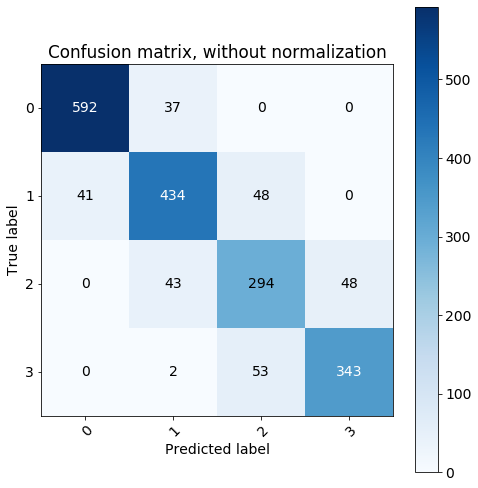

In [55]:
from sklearn.metrics import confusion_matrix 
y_true = np.array(y_test)
y_pred = grid.predict(X_test)
plot_confusion_matrix(y_true, y_pred, classes=[0,1,2,3])
print(sum(y_true==y_pred)/len(y_true))

In [69]:
from sklearn.metrics import classification_report

In [70]:
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred)
print(sk_report)

              precision    recall  f1-score   support

           0   0.935229  0.941176  0.938193       629
           1   0.841085  0.829828  0.835419       523
           2   0.744304  0.763636  0.753846       385
           3   0.877238  0.861809  0.869455       398

    accuracy                       0.859432      1935
   macro avg   0.849464  0.849112  0.849228      1935
weighted avg   0.859868  0.859432  0.859598      1935

